# SERPRO - Weather

_Previsão de temperaturas médias com base em dados históricos_

https://www.kaggle.com/c/serpro-weather/

## Referências

### Forecasting Time Series with Multiple Seasonalities using TBATS in Python
- https://medium.com/intive-developers/forecasting-time-series-with-multiple-seasonalities-using-tbats-in-python-398a00ac0e8a

### Forecasting Time Series With Complex Seasonal Patterns Using Exponential Smoothing
- https://www.tandfonline.com/doi/abs/10.1198/jasa.2011.tm09771

### TBATS Model (Exponential Smoothing State Space Model With Box-Cox Transformation, ARMA Errors, Trend And Seasonal Components)
- https://www.rdocumentation.org/packages/forecast/versions/8.4/topics/tbats

## Importação dos pacotes

In [1]:
# importar pacotes necessários
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
#import matplotlib.pyplot as plt
import pickle

In [2]:
# definir parâmetros extras
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

## Definição de parâmetros

In [3]:
# definir períodos a serem considerados no modelo
periodo1 = 1.0
periodo2 = 365.25

# definir data inicial de corte
data_inicio_amostra = '2014-11'

In [4]:
print('Períodos sazonais: (%.2f, %.2f)' % (periodo1, periodo2))
print('Data de início da amostra:', data_inicio_amostra)

Períodos sazonais: (1.00, 365.25)
Data de início da amostra: 2014-11


## Carga dos dados

In [5]:
prefixo_arquivos = ''
#prefixo_arquivos = 'https://github.com/hjort/ai-labs/raw/master/kaggle/serpro-weather/'

In [6]:
# carregar arquivo de dados de treino
train_data = pd.read_csv(prefixo_arquivos + 'weather-train.csv', index_col='date', parse_dates=['date'])
train_data.info()
train_data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1508 entries, 2012-10-01 to 2016-11-16
Data columns (total 1 columns):
temperature    1507 non-null float64
dtypes: float64(1)
memory usage: 23.6 KB


,temperature
date,
2012-10-01,11.036840
2012-10-02,14.340558
2012-10-03,14.518382
2012-10-04,16.820351
2012-10-05,16.948431


In [7]:
# carregar arquivo de dados de teste
test_data = pd.read_csv(prefixo_arquivos + 'weather-test.csv', index_col='date', parse_dates=['date'])
test_data.info()
test_data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 378 entries, 2016-11-17 to 2017-11-29
Empty DataFrame

""
date
2016-11-17
2016-11-18
2016-11-19
2016-11-20
2016-11-21


## Transformações nos dados

In [8]:
# remover valores nulos
data = train_data.dropna()

# reduzir a quantidade de dados para a frequência
##data = data.resample(frequencia).mean()

# filtrar período desejado
#data = data[data_inicio_amostra:]
#data = data['2013-01':]
#data = data['2013-01':'2015-12']

# converter temperatura para Kelvin
#data['temperature'] += 273.15

data.head()

,temperature
date,
2012-10-01,11.036840
2012-10-02,14.340558
2012-10-03,14.518382
2012-10-04,16.820351
2012-10-05,16.948431


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1507 entries, 2012-10-01 to 2016-11-16
Data columns (total 1 columns):
temperature    1507 non-null float64
dtypes: float64(1)
memory usage: 23.5 KB


In [10]:
data.describe()

,temperature
count,1507.000000
mean,12.685589
std,11.516132
min,-20.568680
25%,3.949332
50%,13.665819
75%,22.204917
max,35.738109


## Análise da série temporal

In [11]:
# criar série temporal a partir do dataframe
ts = data['temperature']
#ts = ts.asfreq('D')
ts.head()

date
2012-10-01    11.036840
2012-10-02    14.340558
2012-10-03    14.518382
2012-10-04    16.820351
2012-10-05    16.948431
Name: temperature, dtype: float64

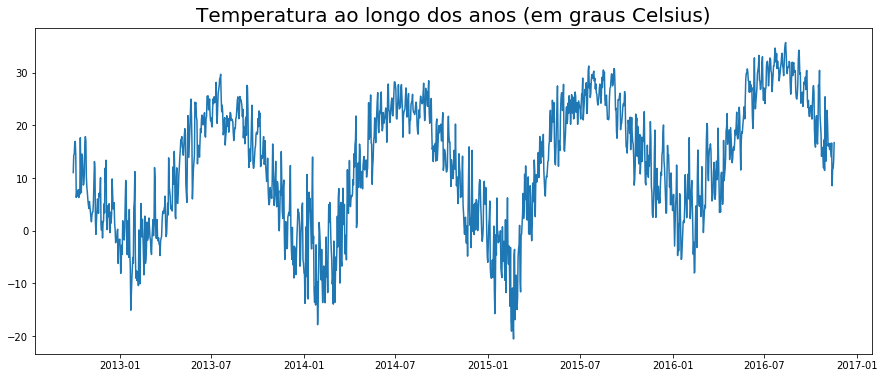

In [12]:
# plotar a série temporal
plt.plot(ts)
plt.title('Temperatura ao longo dos anos (em graus Celsius)', fontsize=20)
plt.show()

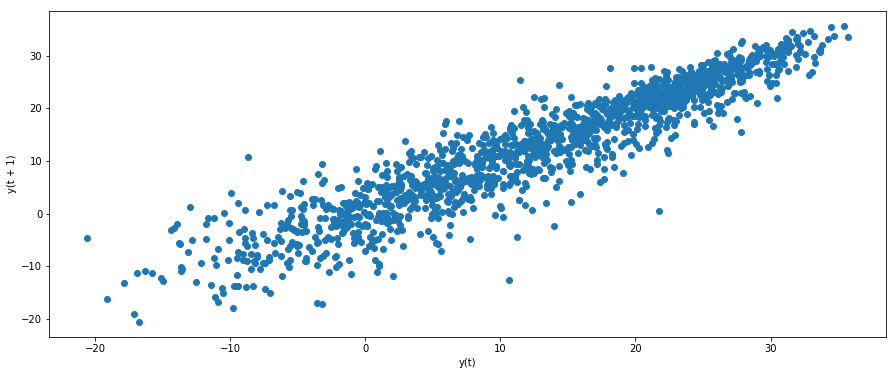

In [13]:
# https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html#visualization-lag

from pandas.plotting import lag_plot

lag_plot(ts)

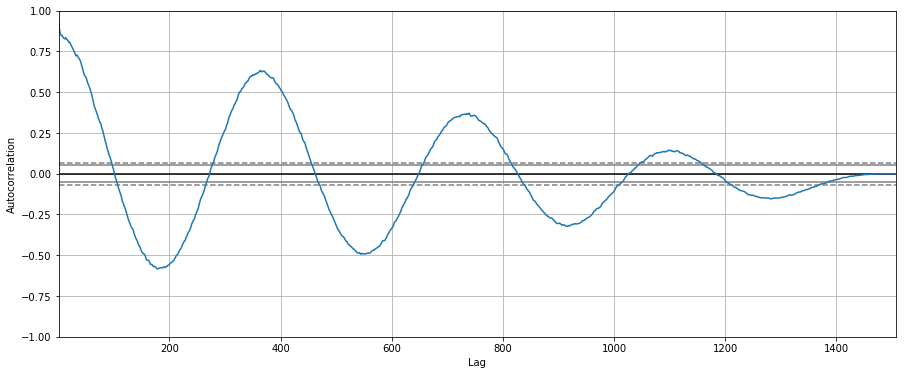

In [14]:
# https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html#visualization-autocorrelation

# analisar sazonalidade na série através da autocorrelação
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(ts)

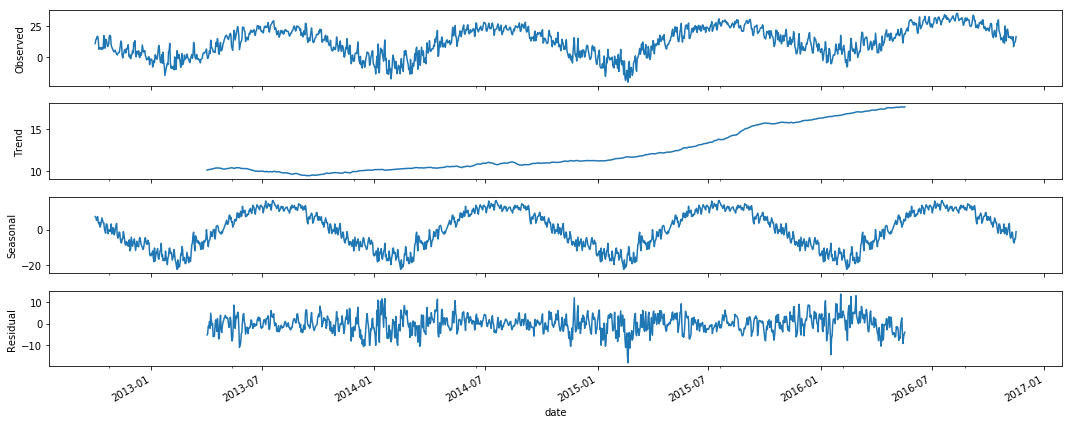

In [15]:
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(ts, model='additive', freq=365)
#result = seasonal_decompose(ts + 273.15, model='multiplicative', freq=365)
result.plot()
plt.show()

## Modelagem preditiva

### Preditor automático TBATS
- https://github.com/intive-DataScience/tbats

In [16]:
# dividir dados entre treino e teste
corte = (len(ts) - 365) # 1 ano
#corte = int(len(ts) * 0.75)
treino = ts[:corte]
teste = ts[corte:]
print('Treino:', treino.shape)
print('Teste: ', teste.shape)

Treino: (1142,)
Teste:  (365,)


In [17]:
from tbats import TBATS, BATS

model = TBATS(seasonal_periods=(periodo1, periodo2), use_trend=True)
%time smodel = model.fit(treino)

print('\n' + smodel.summary())

/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: InputArgsWarning: All seasonal periods should be values greater than 1. Ignoring all seasonal period values that do not meet this condition.
  warnings.warn(message, warning_type)


CPU times: user 1.91 s, sys: 142 ms, total: 2.06 s
Wall time: 37.6 s

Use Box-Cox: False
Use trend: True
Use damped trend: True
Seasonal periods: [365.25]
Seasonal harmonics [1]
ARMA errors (p, q): (0, 3)
Smoothing (Alpha): 0.787719
Trend (Beta): -0.141682
Damping Parameter (Phi): 0.801523
Seasonal Parameters (Gamma): [6.14736958e-05 2.78309904e-05]
AR coefficients []
MA coefficients [ 2.78309904e-05 -2.52067227e-01 -7.88798985e-02]
Seed vector [  9.56063926  -1.00012437   0.53478497 -11.33436403   0.
   0.           0.        ]

AIC 11154.265678


### Avaliação do resultado em previsões futuras

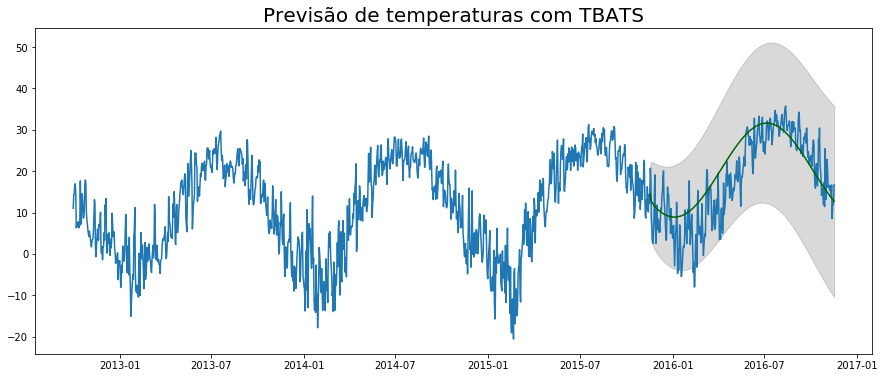

In [18]:
# realizar a previsão
fitted, confidence = smodel.forecast(steps=len(teste), confidence_level=0.95)
index_of_fc = pd.date_range(teste.index[0], periods=len(teste), freq='D')

# criar séries para plotagem
fitted_series = pd.Series(confidence['mean'], index=index_of_fc)
lower_series = pd.Series(confidence['lower_bound'], index=index_of_fc)
upper_series = pd.Series(confidence['upper_bound'], index=index_of_fc)

# plotar gráfico
plt.plot(ts)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index,
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
plt.title("Previsão de temperaturas com TBATS", fontsize=20)
plt.show()

In [19]:
def rmse(predictions, targets):
    assert len(predictions) == len(targets)
    return np.sqrt(np.mean((predictions - targets) ** 2))

def rmsle(predictions, targets):
    assert len(predictions) == len(targets)
    return np.sqrt(np.mean((np.log(1 + predictions) - np.log(1 + targets)) ** 2))

In [20]:
print('RMSE:', rmse(fitted_series, teste))

RMSE: 6.338708043856819


### Previsão de valores futuros com os dados de teste

In [21]:
from tbats import TBATS, BATS

model = TBATS(seasonal_periods=(periodo1, periodo2), use_trend=True)
%time smodel = model.fit(ts)

print('\n' + smodel.summary())

/dados/anaconda3/lib/python3.7/site-packages/tbats/error/ExceptionHandler.py:13: InputArgsWarning: All seasonal periods should be values greater than 1. Ignoring all seasonal period values that do not meet this condition.
  warnings.warn(message, warning_type)


CPU times: user 3.44 s, sys: 135 ms, total: 3.58 s
Wall time: 36.6 s

Use Box-Cox: False
Use trend: True
Use damped trend: False
Seasonal periods: [365.25]
Seasonal harmonics [1]
ARMA errors (p, q): (2, 2)
Smoothing (Alpha): 1.211942
Trend (Beta): 0.102199
Damping Parameter (Phi): 1.000000
Seasonal Parameters (Gamma): [-4.34609049e-05 -5.48065267e-05]
AR coefficients [-5.48065267e-05  8.54474566e-02]
MA coefficients [-0.59699595 -0.34794938]
Seed vector [  7.40422278  -1.00813536   2.5963978  -10.71332494   0.
   0.           0.           0.        ]

AIC 15095.057306


In [22]:
# obter intervalo de datas para a previsão
primeira_data = test_data.index[0]
ultima_data = test_data.index[-1]
print('Intervalo de datas: %s => %s' % (primeira_data, ultima_data))
datas_previsao = test_data.index
#datas_previsao

Intervalo de datas: 2016-11-17 00:00:00 => 2017-11-29 00:00:00


In [23]:
# gerar novos valores a partir do modelo
periodos_previsao = len(datas_previsao)
valores_previstos, confianca = smodel.forecast(steps=len(datas_previsao), confidence_level=0.95)

In [24]:
# construir dataframe com previsão
df = pd.DataFrame({
    'date': datas_previsao,
    'temperature': valores_previstos
})
df.set_index('date', inplace=True)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 378 entries, 2016-11-17 to 2017-11-29
Data columns (total 1 columns):
temperature    378 non-null float64
dtypes: float64(1)
memory usage: 5.9 KB


,temperature
date,
2016-11-17,15.399084
2016-11-18,13.993661
2016-11-19,13.466629
2016-11-20,13.179433
2016-11-21,12.968985


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 378 entries, 2016-11-17 to 2017-11-29
Data columns (total 1 columns):
temperature    378 non-null float64
dtypes: float64(1)
memory usage: 5.9 KB


In [26]:
# obter intervalo de datas necessário
data_inicio = test_data.index[0]
data_final = test_data.index[-1]
print('Intervalo necessário:', data_inicio, '=>', data_final)

Intervalo necessário: 2016-11-17 00:00:00 => 2017-11-29 00:00:00


In [27]:
# restringir ao intervalo de datas esperado
pred_data = df
#pred_data = pred_data[data_inicio:data_final]

# converter temperaturas novamente para graus Celsius
#pred_data['temperature'] -= 273.15

# exibir informações do dataframe
pred_data.info()
pred_data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 378 entries, 2016-11-17 to 2017-11-29
Data columns (total 1 columns):
temperature    378 non-null float64
dtypes: float64(1)
memory usage: 5.9 KB


,temperature
date,
2016-11-17,15.399084
2016-11-18,13.993661
2016-11-19,13.466629
2016-11-20,13.179433
2016-11-21,12.968985


## Geração do arquivo de resultados

In [28]:
# criar diretório de submissões
!dd="submissions/"; if [ ! -d $dd ]; then mkdir $dd; fi

In [29]:
# gravar arquivo CSV com os resultados
nome_arquivo = 'submissions/weather-submission-tbats-' + \
    '%.2f-%.2f-' % (periodo1, periodo2) + \
    data_inicio_amostra + '.csv'
pred_data.to_csv(nome_arquivo)
print('Arquivo gravado com sucesso:', nome_arquivo)

Arquivo gravado com sucesso: submissions/weather-submission-tbats-1.00-365.25-2014-11.csv


## Comparação da previsão com dados reais

In [30]:
# carregar dados reais
real_data = pd.read_csv(prefixo_arquivos + 'weather-solution.csv', index_col='date', parse_dates=['date'])
real_data.head().T

FileNotFoundError: File b'weather-solution.csv' does not exist

In [ ]:
# comparação com os dados reais
plt.plot(pred_data)
plt.plot(real_data)
plt.title('Temperaturas previstas x reais', fontsize=20)
plt.show()

### Medição do Erro Médio Quadrático (RMSE)

In [ ]:
print('RMSE:', rmse(pred_data['temperature'], real_data['temperature']))